Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# Import libs
# Also remember to use GPU in your colab notebook
%tensorflow_version 1.x

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import math
from math import nan
import random
import json
from future.utils import iteritems
import pickle
from requests import get

# Needed for using CRF
!pip install git+https://www.github.com/keras-team/keras-contrib.git

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Input
# from keras.layers import CuDNNLSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-npjdhb02
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-npjdhb02
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=9b9228bdd398b8125970cb0bdc49c8b887ad2991a9fef5a635f6f06c8635d0a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-53a00isg/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


Using TensorFlow backend.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=c475afcf0c5e2bc54e716f2400a88fa0ff98e73d88d7d166ed28c8aeb9611eb5
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1iTLWWB9aFjtjVz7Kq4ku2syjhINCz2_q'
DATA_TRAINING_FILENAME = 'ner_medical_training.csv'
DATA_DEV_FILE_ID = '1fB1Mp-6_zxGC3NO5sMX23B-LPyYzc9I9'
DATA_DEV_FILENAME = 'ner_medical_dev.csv'
DATA_TEST_FILE_ID = '17vmu2VXPwvOKuQ66kDY7t38dFqkYccvx'
DATA_TEST_FILENAME = 'ner_medical_test.csv'
BACKUP_FOLDER_ID = '1EwDUGjrtg8AiUhBFAImg5vEUXxYEqQcS'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  1000
Number of dev sentences:  1000
Number of test sentences:  1000
Number of words in the training dataset:  10405
Number of words in the dev dataset:  10246
Number of words in the test dataset:  10814
Tags in the training dataset: ['I-Chemical', 'B-Disease', 'I-Disease', 'B-Chemical', 'O']
Number of Labels in the training dataset:  5
Tags in the dev dataset: ['I-Chemical', 'B-Disease', 'I-Disease', 'B-Chemical', 'O']
Number of Labels in the dev dataset:  5
Tags in the test dataset: ['I-Chemical', 'B-Disease', 'I-Disease', 'B-Chemical', 'O']
Number of Labels in the test dataset:  5
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 1,Naloxone,B-Chemical
1,Sentence: 1,reverses,O
2,Sentence: 1,the,O
3,Sentence: 1,antihypertensive,O
4,Sentence: 1,effect,O
5,Sentence: 1,of,O
6,Sentence: 1,clonidine,B-Chemical
7,Sentence: 1,.,O
8,Sentence: 2,In,O
9,Sentence: 2,unanesthetized,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Intravenous', 'O'),
 ('administration', 'O'),
 ('of', 'O'),
 ('prochlorperazine', 'B-Chemical'),
 ('by', 'O'),
 ('15', 'O'),
 ('-', 'O'),
 ('minute', 'O'),
 ('infusion', 'O'),
 ('versus', 'O'),
 ('2', 'O'),
 ('-', 'O'),
 ('minute', 'O'),
 ('bolus', 'O'),
 ('does', 'O'),
 ('not', 'O'),
 ('affect', 'O'),
 ('the', 'O'),
 ('incidence', 'O'),
 ('of', 'O'),
 ('akathisia', 'B-Disease'),
 (':', 'O'),
 ('a', 'O'),
 ('prospective', 'O'),
 (',', 'O'),
 ('randomized', 'O'),
 (',', 'O'),
 ('controlled', 'O'),
 ('trial', 'O'),
 ('.', 'O')]

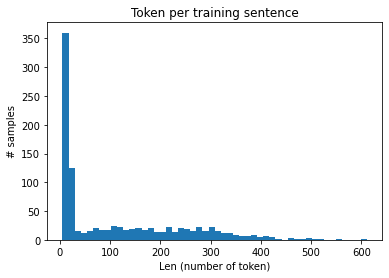

In [ ]:
# Explore set of sentences
# Plot sentences by length
import matplotlib.pyplot as plt
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

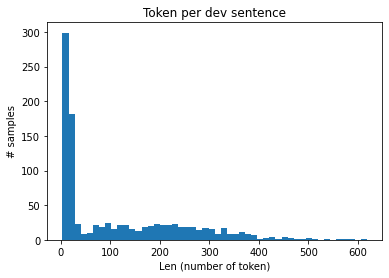

In [ ]:
# Explore set of sentences
# Plot sentences by length
import matplotlib.pyplot as plt
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

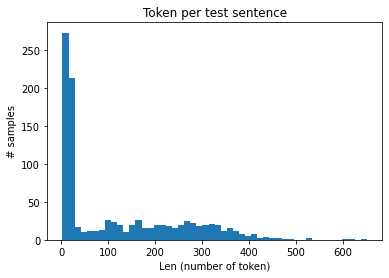

In [ ]:
# Explore set of sentences
# Plot sentences by length
import matplotlib.pyplot as plt
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'delirium'
print(word2idx['delirium'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-Chemical'
print(tag2idx['B-Chemical'])
# Tag of index 4
print(idx2tag[4])

7038
R2
3
O


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = math.ceil(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.9)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 1000
Points in y_train before removal: 1000
Points in X_train before removal: 100
Points in y_train before removal: 100


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['delirium'])
print(tag2idx['B-Chemical'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[6232, 2456, 763, 716, 2379, 9394, 12590, 14569, 12301, 5796, 15295, 1925, 6582]
[4, 4, 1, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4]
[8965, 3002, 714, 16997, 14142, 14655, 6844, 11080, 14301, 14160, 14766, 6582]
[1, 2, 2, 4, 3, 0, 1, 4, 4, 4, 4, 4]
[9705, 3023, 14996, 7038, 6582, 18258, 11933, 12590, 7307, 4040, 6582]
[3, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4]
7038
3
I-Disease
vancomycin
18533
5


In [ ]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
%tensorflow_version 1.x
!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1EwDUGjrtg8AiUhBFAImg5vEUXxYEqQcS'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.fillna(method="ffill")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['delirium'])
print(tag2idx['B-Chemical'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-j201bgqh
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-j201bgqh
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[6232, 2456, 763, 716, 2379, 9394, 12590, 14569, 12301, 5796, 15295, 1925, 6582]
[4, 4, 1, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4]
[8965, 3002, 714, 16997, 14142, 14655, 6844, 11080, 14301, 14160, 14766, 6582]
[1, 2, 2, 4, 3, 0, 1, 4, 4, 4, 4, 4]
[9705, 3023, 14996, 7038, 6582, 18258, 11933, 12590, 7307, 4040, 6582]
[3, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4]
7038
3
I-Disease
vancomycin
18533
5


In [ ]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [ ]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [ ]:
# Graph plot function 
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['crf_viterbi_accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [ ]:
# This function converts predicted values to labels from idx2tag
# This is to improve the interpretability of the results
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [ ]:
# Model creation function
def create_model(maxlen, n_words):
  input = Input(shape=(maxlen,))
  word_embedding_size = 150

  model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=maxlen)(input)
  model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5))(model)
  model = TimeDistributed(Dense(n_tags,
                                activation="relu"))(model)  
  crf = CRF(n_tags)
  out = crf(model)
  model = Model(input, out)

  adam = k.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
  model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])
  model.summary()

  return model

In [ ]:
# Model training function
def train(model, X_train_df, y_train_df, X_dev_df, y_dev_df):
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.0001, verbose=1)
  callbacks_list = [early_stopping]

  history = model.fit(X_train_df, np.array(y_train_df),
                      batch_size=(round(0.05*len(X_train_df)) if round(0.05*len(X_train_df)) > 10 else 10),
                      epochs=100,
                      validation_data=(X_dev_df,  np.array(y_dev_df)),
                      verbose=1,
                      callbacks=callbacks_list)
  plot_history(history)

In [ ]:
# Model testing function
def test(model, X_test_df, y_test_df):
  test_pred = model.predict(X_test_df, verbose=1)   

  pred_labels = pred2label(test_pred)
  test_labels = pred2label(y_test_df)
  
  print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
  report = classification_report(y_pred=pred_labels, y_true=test_labels, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print("Classification Report:")
  print(df.to_csv())

In [ ]:
def create_train_and_validate_model(augmented_percentage):
  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  # Preparing data for training. 
  # X = observations vector. For text sequence labeling, observations are the index of the words in the sentences
  # y = labels vector. For text sequence labeling, labels are the index of tags in the sentences
  # The BI-LSTM layer expects all texts/sentences to be of the same length. 
  # So, we need to pad shorter sentences
  # We select the padding size to be the length of the longest sentence.

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_dev = max([len(s) for s in y_dev])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_y_test = max([len(s) for s in y_test])

  maxlen = max([maxlen_X_train, maxlen_y_train, maxlen_X_dev, maxlen_y_dev, maxlen_X_test, maxlen_y_test])

  augmented_X_train = pad_sequences(maxlen=maxlen, sequences=augmented_X_train, padding="post",value=n_words - 1)
  new_X_dev = pad_sequences(maxlen=maxlen, sequences=X_dev, padding="post",value=n_words - 1)
  new_X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=n_words - 1)

  augmented_y_train = pad_sequences(maxlen=maxlen, sequences=augmented_y_train, padding="post", value=tag2idx["O"])
  new_y_dev = pad_sequences(maxlen=maxlen, sequences=y_dev, padding="post", value=tag2idx["O"])
  new_y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])

  # Converts vector y (integers) to binary matrix.
  # Each y is a one-hot vector where only the position of the tag gests "1"
  augmented_y_train = [to_categorical(i, num_classes=n_tags) for i in augmented_y_train]
  new_y_dev = [to_categorical(i, num_classes=n_tags) for i in new_y_dev]
  new_y_test = [to_categorical(i, num_classes=n_tags) for i in new_y_test]

  model = None
  model = create_model(maxlen, n_words)

  train(model, augmented_X_train, augmented_y_train, new_X_dev, new_y_dev)

  test(model, new_X_test, new_y_test)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_1 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________

Train on 100 samples

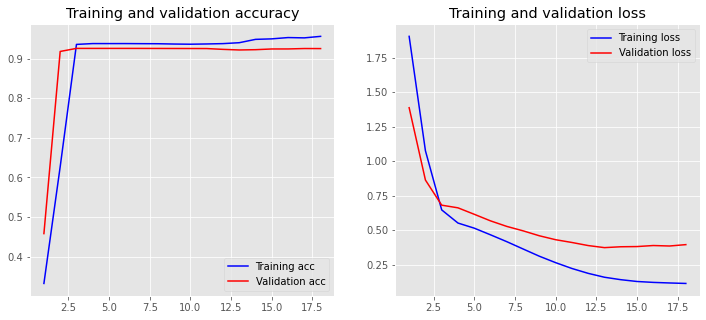

1000/1000 [==============================] - 21s 21ms/step
F1-score: 3.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.08287172803301836,0.037589910335993695,0.05172004744958482,20298.0
Disease,0.34523809523809523,0.0016989864666940068,0.0033813327114790414,17069.0
micro avg,0.08524378430739425,0.021195172210774212,0.033949161987226195,37367.0
macro avg,0.2140549116355568,0.019644448401343852,0.02755069008053193,37367.0
weighted avg,0.20271896013148646,0.021195172210774212,0.02963924027039656,37367.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_2 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 100 samples, validate on 1000 samples
Epoch 1/100
100/100 [==============================] - 109s 1s/step 

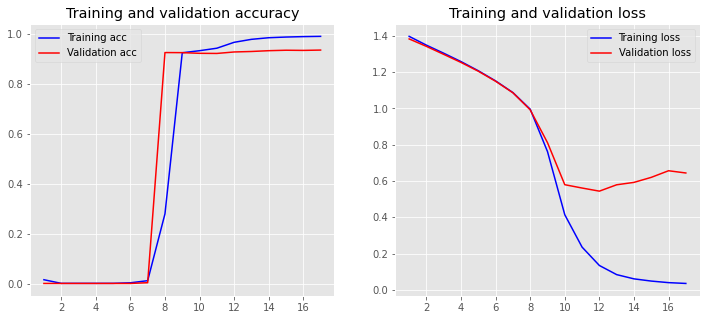

1000/1000 [==============================] - 21s 21ms/step
F1-score: 14.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.21226080793763288,0.11804118632377573,0.1517127841448743,20298.0
Disease,0.3505850585058506,0.09127658327962974,0.14484265327941248,17069.0
micro avg,0.2513348588863463,0.1058152915674258,0.14892935836833088,37367.0
macro avg,0.2814229332217417,0.10465888480170274,0.1482777187121434,37367.0
weighted avg,0.275446416441096,0.1058152915674258,0.1485745535204579,37367.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_3 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 100 samples, validate on 1000 samples
Epoch 1/100
100/100 [==============================] - 109s 1s/step 

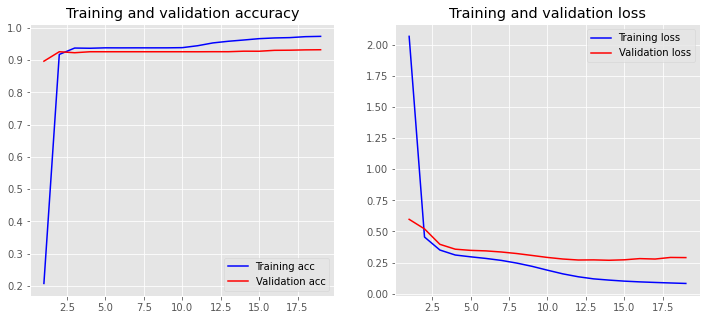

1000/1000 [==============================] - 21s 21ms/step
F1-score: 10.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.23028309237295472,0.1310473938319046,0.16703821156080254,20298.0
Disease,0.01997780244173141,0.0010545433241549006,0.0020033388981636055,17069.0
micro avg,0.21506585287504015,0.07166751411673401,0.1075091832433409,37367.0
macro avg,0.12513044740734305,0.06605096857802975,0.08452077522948306,37367.0
weighted avg,0.1342170181942395,0.07166751411673401,0.09165136644402613,37367.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_4 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 100 samples, validate on 1000 samples
Epoch 1/100
100/100 [==============================] - 109s 1s/step 

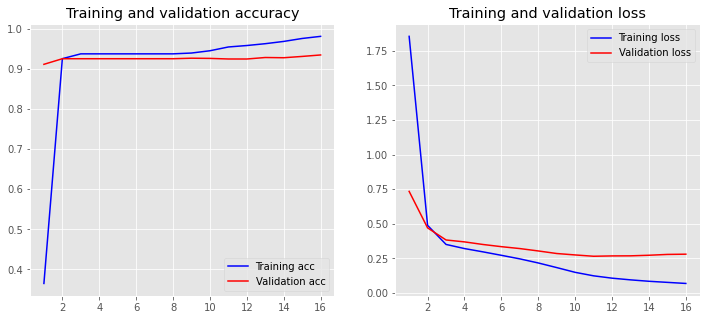

1000/1000 [==============================] - 21s 21ms/step
F1-score: 10.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.26529796027196373,0.09803921568627451,0.14317061764811684,20298.0
Disease,0.23198294243070364,0.031870642685570334,0.05604203152364273,17069.0
micro avg,0.25736339630306726,0.0678138464420478,0.10734331645944974,37367.0
macro avg,0.24864045135133367,0.06495492918592242,0.09960632458587979,37367.0
weighted avg,0.25007987908983864,0.0678138464420478,0.10337085217166306,37367.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_5 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 100 samples, validate on 1000 samples
Epoch 1/100
100/100 [==============================] - 109s 1s/step 

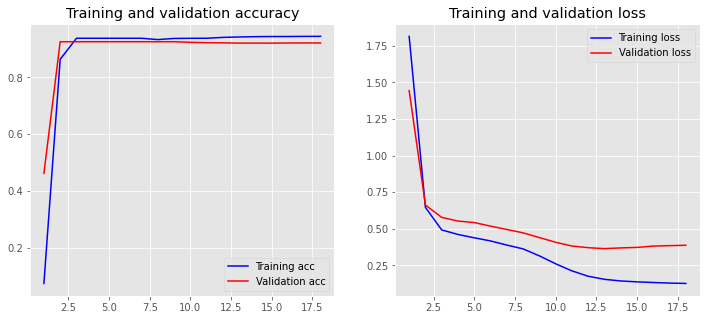

1000/1000 [==============================] - 21s 21ms/step
F1-score: 8.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.16404962262514097,0.09316188787072618,0.11883739198743128,20298.0
Disease,0.08841940532081377,0.006620188646083543,0.01231809015097836,17069.0
micro avg,0.15650136665365091,0.053630208472716566,0.07988519492944271,37367.0
macro avg,0.12623451397297736,0.049891038258404866,0.06557774106920482,37367.0
weighted avg,0.12950223645104186,0.053630208472716566,0.0701800750220229,37367.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_6 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 100 samples, validate on 1000 samples
Epoch 1/100
100/100 [==============================] - 110s 1s/step 

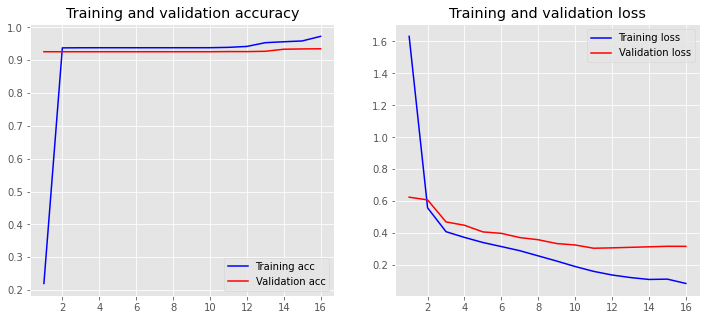

1000/1000 [==============================] - 21s 21ms/step
F1-score: 4.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.26727509778357234,0.04804030698927881,0.08144212146794458,17069.0
micro avg,0.2645161290322581,0.021944496480852088,0.040526849037487336,37367.0
macro avg,0.13363754889178617,0.024020153494639405,0.04072106073397229,37367.0
weighted avg,0.12208950796338472,0.021944496480852088,0.037202225796460674,37367.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_7 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_7 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 100 samples, validate on 1000 samples
Epoch 1/100
100/100 [==============================] - 109s 1s/step 

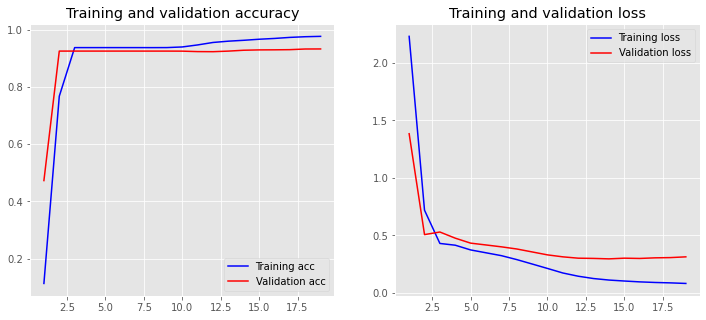

1000/1000 [==============================] - 21s 21ms/step
F1-score: 10.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.25187859861422857,0.1271553847669721,0.16899656244884598,20298.0
Disease,0.048044692737430165,0.002519186829925596,0.0047873524827432646,17069.0
micro avg,0.23550529527912403,0.07022238873872669,0.10818610979405885,37367.0
macro avg,0.14996164567582937,0.06483728579844886,0.08689195746579462,37367.0
weighted avg,0.1587686101374691,0.07022238873872669,0.0939868746250601,37367.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_8 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 100 samples, validate on 1000 samples
Epoch 1/100
100/100 [==============================] - 110s 1s/step 

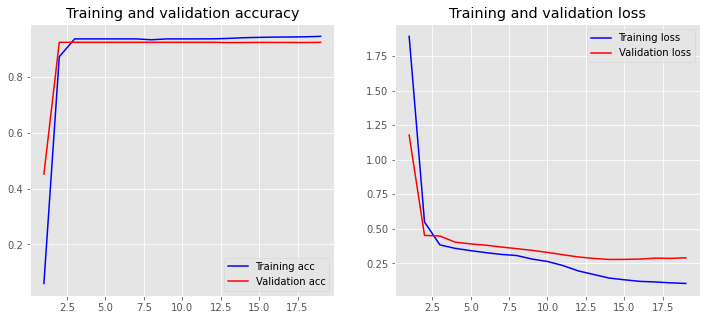

1000/1000 [==============================] - 22s 22ms/step
F1-score: 6.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.060240963855421686,0.00024632968765395607,0.0004906530592218242,20298.0
Disease,0.19003508771929825,0.07932509227254086,0.1119285773332231,17069.0
micro avg,0.1885405105438402,0.03636898867985121,0.06097588334268088,37367.0
macro avg,0.12513802578735997,0.03978571098009741,0.056209615196222466,37367.0
weighted avg,0.11953006654583057,0.03636898867985121,0.0513947644257465,37367.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_9 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_9 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 100 samples, validate on 1000 samples
Epoch 1/100
100/100 [==============================] - 110s 1s/step 

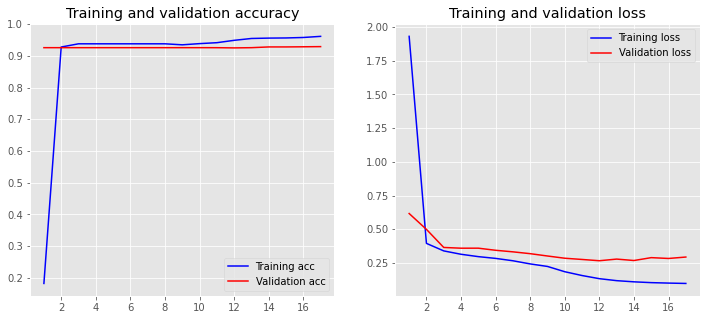

1000/1000 [==============================] - 22s 22ms/step
F1-score: 6.9%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.3582126809785322,0.08407053723123792,0.1361803084223013,17069.0
micro avg,0.3582126809785322,0.038402868841491154,0.06936891209242743,37367.0
macro avg,0.1791063404892661,0.04203526861561896,0.06809015421115065,37367.0
weighted avg,0.16362919826645345,0.038402868841491154,0.0622062698225777,37367.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_10 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 100 samples, validate on 1000 samples
Epoch 1/100
100/100 [==============================] - 110s 1s/step

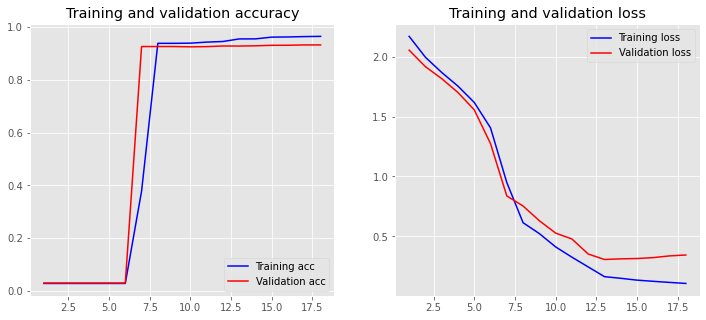

1000/1000 [==============================] - 22s 22ms/step
F1-score: 12.7%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.2658984208279983,0.18249458081902864,0.2164396887159533,17069.0
micro avg,0.2658984208279983,0.08336232504616373,0.12693044293223585,37367.0
macro avg,0.13294921041399915,0.09124729040951432,0.10821984435797664,37367.0
weighted avg,0.12146065097848643,0.08336232504616373,0.09886822722435858,37367.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 125
Points in y_train after augmentation: 125


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_11 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_11 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 125 samples, validate on 1000 samples
Epoch 1/100
125/125 [==============================] - 115s 922ms/s

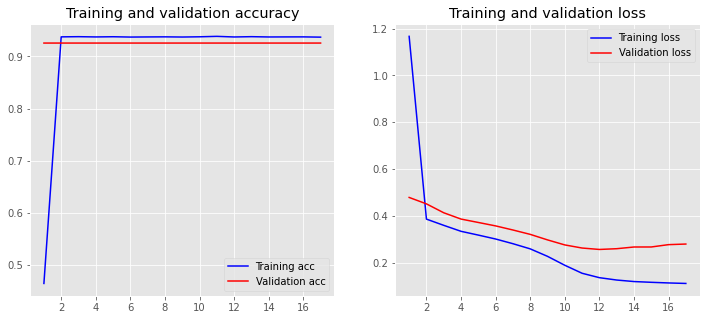

1000/1000 [==============================] - 22s 22ms/step
F1-score: 0.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.0,0.0,0.0,37367.0
macro avg,0.0,0.0,0.0,37367.0
weighted avg,0.0,0.0,0.0,37367.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 125
Points in y_train after augmentation: 125


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_12 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 125 samples, validate on 1000 samples
Epoch 1/100
125/125 [==============================] - 115s 922ms/s

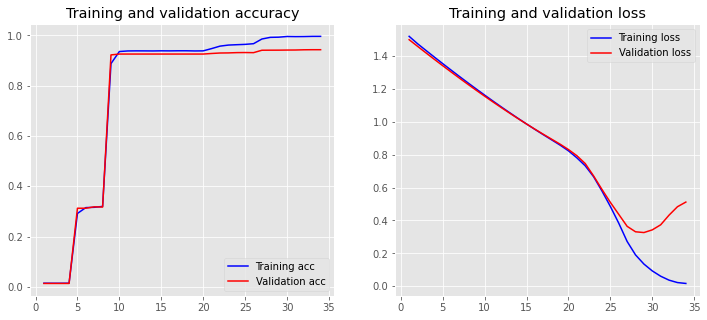

1000/1000 [==============================] - 23s 23ms/step
F1-score: 38.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8148884133292571,0.2626367129766479,0.39724292101341285,20298.0
Disease,0.46481838919108615,0.31038725174292575,0.37222046580250817,17069.0
micro avg,0.5924749163879599,0.28444884523777664,0.38436364293850683,37367.0
macro avg,0.6398534012601717,0.2865119823597868,0.38473169340796054,37367.0
weighted avg,0.6549787271886935,0.28444884523777664,0.3858128279367695,37367.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 125
Points in y_train after augmentation: 125


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_13 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_13 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 125 samples, validate on 1000 samples
Epoch 1/100
125/125 [==============================] - 116s 931ms/s

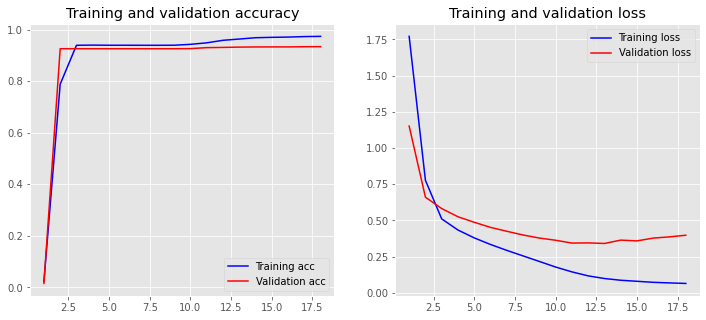

1000/1000 [==============================] - 23s 23ms/step
F1-score: 18.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.41127790608160125,0.21056261700660164,0.27852720755946564,20298.0
Disease,0.136986301369863,0.0029292870115413907,0.005735918320523116,17069.0
micro avg,0.4019708097053082,0.11571707656488345,0.1797024353752805,37367.0
macro avg,0.27413210372573216,0.10674595200907151,0.14213156293999438,37367.0
weighted avg,0.2859833038704347,0.11571707656488345,0.15391793959523223,37367.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 125
Points in y_train after augmentation: 125


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_14 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_14 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 125 samples, validate on 1000 samples
Epoch 1/100
125/125 [==============================] - 118s 941ms/s

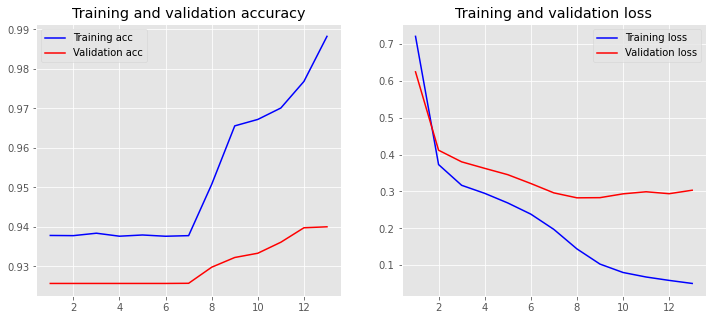

1000/1000 [==============================] - 23s 23ms/step
F1-score: 10.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.4069406392694064,0.10976450881860282,0.17289411399526639,20298.0
Disease,0.01928374655647383,0.0016404007264631789,0.003023594838291669,17069.0
micro avg,0.3256821134690342,0.06037412690341745,0.10186481238993994,37367.0
macro avg,0.2131121929129401,0.055702454772533,0.08795885441677903,37367.0
weighted avg,0.22986151860900964,0.06037412690341745,0.09529837734286181,37367.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 125
Points in y_train after augmentation: 125


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_15 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_15 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 125 samples, validate on 1000 samples
Epoch 1/100
125/125 [==============================] - 120s 958ms/s

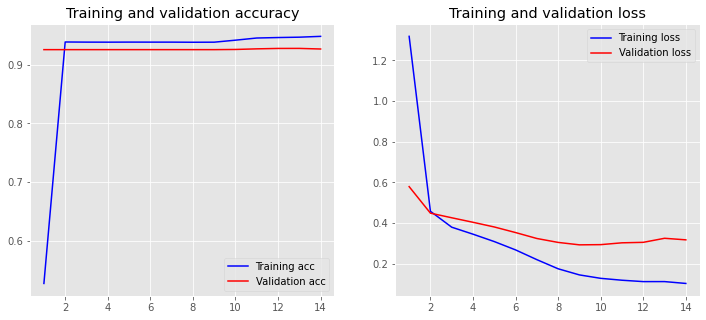

1000/1000 [==============================] - 23s 23ms/step
F1-score: 0.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.0036496350364963502,4.926593753079121e-05,9.721952167995334e-05,20298.0
Disease,0.039735099337748346,0.0003515144413849669,0.0006968641114982578,17069.0
micro avg,0.01647058823529412,0.00018733106751946905,0.00037044877222692634,37367.0
macro avg,0.02169236718712235,0.00020039018945787907,0.0003970418165891056,37367.0
weighted avg,0.02013323795238658,0.00018733106751946905,0.00037113322905835247,37367.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 125
Points in y_train after augmentation: 125


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_16 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_16 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 125 samples, validate on 1000 samples
Epoch 1/100
125/125 [==============================] - 116s 927ms/s

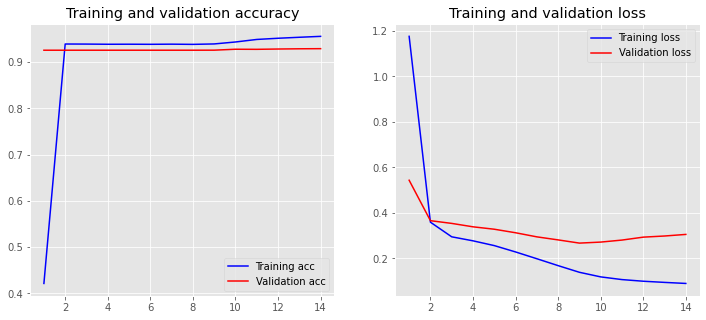

1000/1000 [==============================] - 24s 24ms/step
F1-score: 0.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.05952380952380952,0.0004926593753079121,0.0009772305286817162,20298.0
Disease,0.1375921375921376,0.0032808014529263577,0.006408789196612497,17069.0
micro avg,0.11478260869565217,0.001766264350897851,0.0034789942543882765,37367.0
macro avg,0.09855797355797355,0.001886730414117135,0.0036930098626471067,37367.0
weighted avg,0.09518490867006936,0.001766264350897851,0.0034583308284893135,37367.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 125
Points in y_train after augmentation: 125


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_17 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_17 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 125 samples, validate on 1000 samples
Epoch 1/100
125/125 [==============================] - 117s 936ms/s

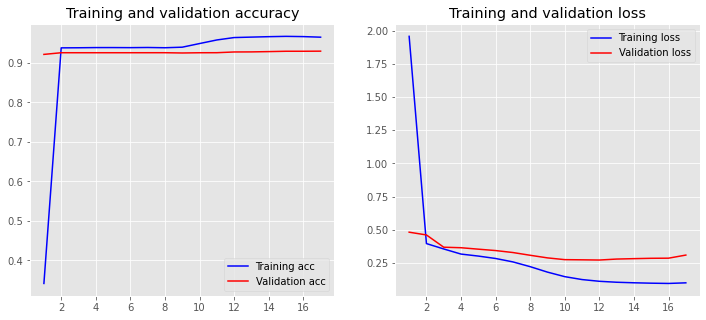

1000/1000 [==============================] - 24s 24ms/step
F1-score: 13.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.2586766721985713,0.1766183860478865,0.20991304856983925,20298.0
Disease,0.03382949932341001,0.0014646435057706954,0.002807726864330638,17069.0
micro avg,0.2472941498835457,0.0966093076778976,0.13893967093235832,37367.0
macro avg,0.14625308576099066,0.08904151477682859,0.10636038771708495,37367.0
weighted avg,0.15596796146968947,0.0966093076778976,0.11530869884437758,37367.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 125
Points in y_train after augmentation: 125


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_18 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_18 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 125 samples, validate on 1000 samples
Epoch 1/100
125/125 [==============================] - 117s 937ms/s

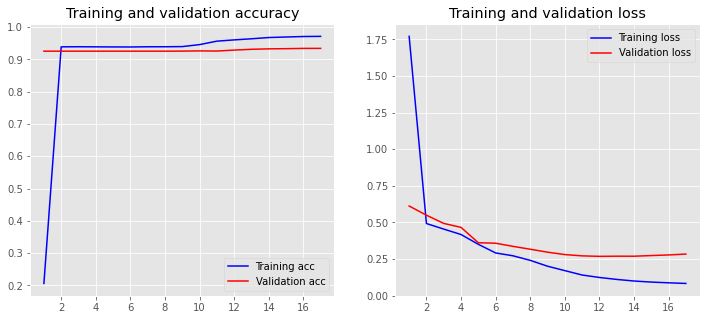

1000/1000 [==============================] - 24s 24ms/step
F1-score: 17.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.3913829180140765,0.20272933293920584,0.26710372582110864,20298.0
Disease,0.022388059701492536,0.00017575722069248346,0.00034877637621345115,17069.0
micro avg,0.38673929376408717,0.11020419086359622,0.17152973029261687,37367.0
macro avg,0.20688548885778452,0.10145254507994916,0.13372625109866104,37367.0
weighted avg,0.22282849200884472,0.11020419086359622,0.14525181820008165,37367.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 125
Points in y_train after augmentation: 125


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_19 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_19 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 125 samples, validate on 1000 samples
Epoch 1/100
125/125 [==============================] - 119s 953ms/s

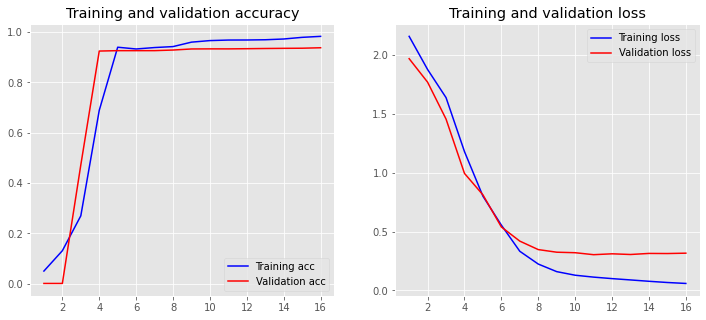

1000/1000 [==============================] - 24s 24ms/step
F1-score: 21.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5118048009483355,0.2552468223470293,0.34061996647053017,20298.0
Disease,0.030737704918032786,0.0008787861034624172,0.0017087201685937231,17069.0
micro avg,0.48968052021487135,0.13905317526159444,0.21659927466755596,37367.0
macro avg,0.2712712529331841,0.12806280422524585,0.17116434331956196,37367.0
weighted avg,0.29205651336460553,0.13905317526159444,0.18580753670288083,37367.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 125
Points in y_train after augmentation: 125


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_20 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_20 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 125 samples, validate on 1000 samples
Epoch 1/100
125/125 [==============================] - 118s 948ms/s

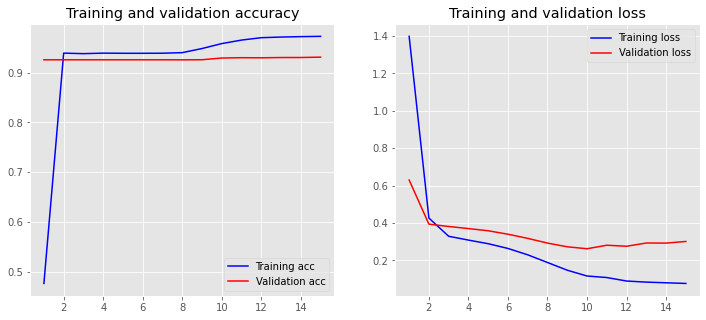

1000/1000 [==============================] - 24s 24ms/step
F1-score: 13.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.25205101689072734,0.18011626761257266,0.21009683073298277,20298.0
Disease,0.029779630732578916,0.0029292870115413907,0.005333902282910177,17069.0
micro avg,0.22899159663865545,0.09917841946102175,0.1384101137233665,37367.0
macro avg,0.14091532381165311,0.09152277731205702,0.10771536650794647,37367.0
weighted avg,0.15051890860444705,0.09917841946102174,0.11656247085088656,37367.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_21 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_21 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 150 samples, validate on 1000 samples
Epoch 1/100
150/150 [==============================] - 122s 814ms/s

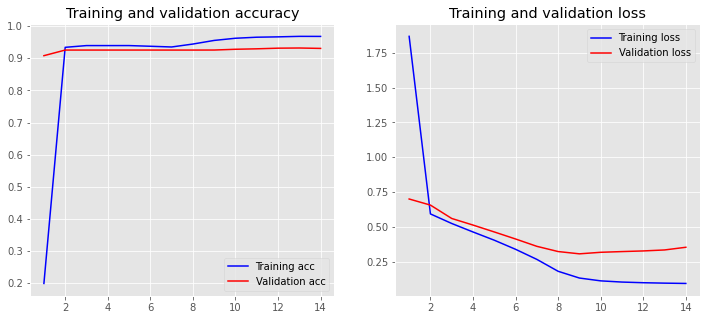

1000/1000 [==============================] - 25s 25ms/step
F1-score: 13.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.2976784178847807,0.17055867573159916,0.21686294161864195,20298.0
Disease,0.01962809917355372,0.0011131290643857285,0.002106780506736154,17069.0
micro avg,0.27631370058739485,0.09315706371932454,0.13933753627539278,37367.0
macro avg,0.15865325852916723,0.08583590239799245,0.10948486106268905,37367.0
weighted avg,0.1706668598233379,0.09315706371932454,0.11876373873858413,37367.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_22 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_22 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 150 samples, validate on 1000 samples
Epoch 1/100
150/150 [==============================] - 122s 815ms/s

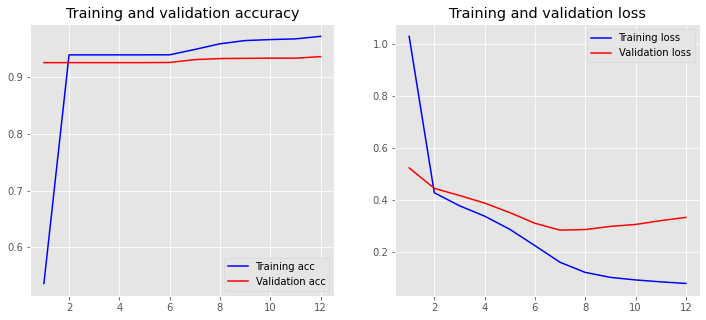

1000/1000 [==============================] - 25s 25ms/step
F1-score: 11.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.5848138233146751,0.11838604788649128,0.1969107223337567,20298.0
Disease,0.054279749478079335,0.0030464584920030465,0.005769124091640317,17069.0
micro avg,0.48450759818433,0.06569968153718522,0.11570910119244003,37367.0
macro avg,0.31954678639637724,0.060716253189247164,0.10133992321269851,37367.0
weighted avg,0.34246934539788076,0.06569968153718522,0.10959849656249637,37367.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_23 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_23 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_23 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 150 samples, validate on 1000 samples
Epoch 1/100
150/150 [==============================] - 122s 816ms/s

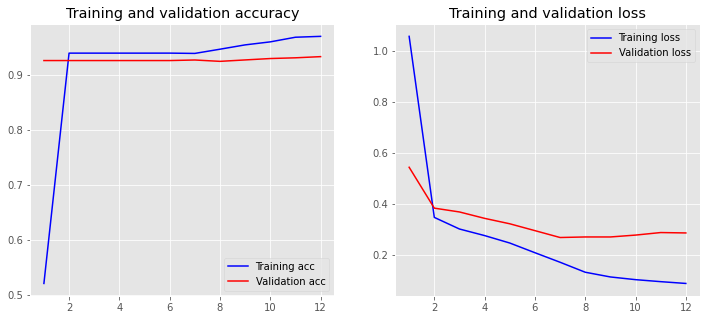

1000/1000 [==============================] - 25s 25ms/step
F1-score: 2.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.07352941176470588,0.0007389890629618681,0.0014632718759145448,20298.0
Disease,0.23215087561742254,0.03028882769933798,0.05358623548922056,17069.0
micro avg,0.2188399835458659,0.014237161131479648,0.026735011809638675,37367.0
macro avg,0.15284014369106422,0.015513908381149924,0.027524753682567554,37367.0
weighted avg,0.1459866538901647,0.014237161131479648,0.025272699068772424,37367.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_24 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_24 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_24 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 150 samples, validate on 1000 samples
Epoch 1/100
150/150 [==============================] - 123s 818ms/s

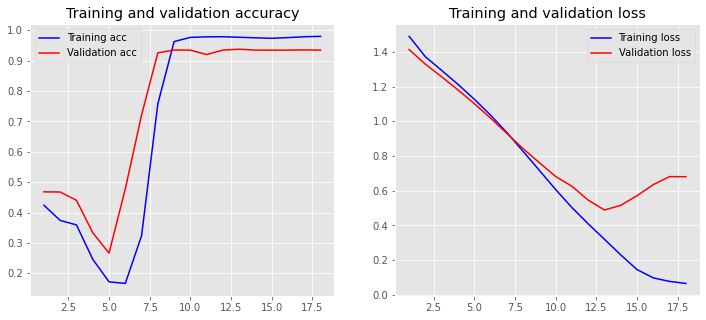

1000/1000 [==============================] - 25s 25ms/step
F1-score: 34.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8193974792499231,0.2626367129766479,0.3977764512759289,20298.0
Disease,0.4060908429477185,0.2288944870818443,0.2927688272761334,17069.0
micro avg,0.5728281763502201,0.24722348596355073,0.345384529106068,37367.0
macro avg,0.6127441610988208,0.2457656000292461,0.34527263927603113,37367.0
weighted avg,0.6306017243045882,0.24722348596355073,0.3498096588105849,37367.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_25 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_25 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_25 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 150 samples, validate on 1000 samples
Epoch 1/100
150/150 [==============================] - 121s 808ms/s

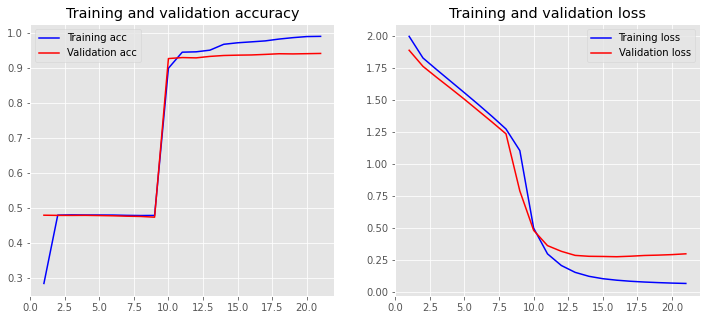

1000/1000 [==============================] - 25s 25ms/step
F1-score: 24.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6056468410090257,0.2578579170361612,0.3617138908085694,20298.0
Disease,0.23293432546101586,0.042181732966196026,0.07142857142857142,17069.0
micro avg,0.5074575982272224,0.15933845371584554,0.24252545824847252,37367.0
macro avg,0.4192905832350208,0.1500198250011786,0.2165712311185704,37367.0
weighted avg,0.43539421361349,0.15933845371584554,0.2291134648579396,37367.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_26 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_26 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_26 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 150 samples, validate on 1000 samples
Epoch 1/100
150/150 [==============================] - 121s 807ms/s

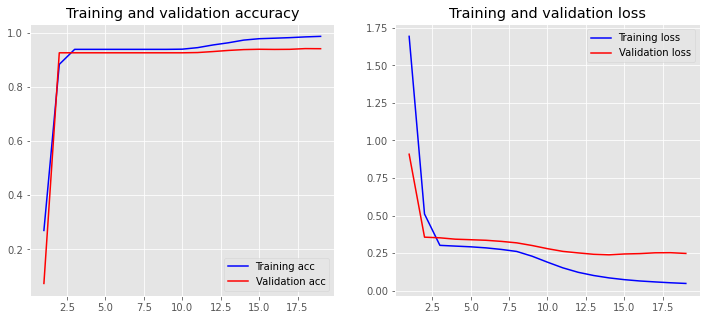

1000/1000 [==============================] - 26s 26ms/step
F1-score: 27.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7953516450347118,0.25963149078726966,0.391472292378547,20298.0
Disease,0.5764331210191083,0.053020094908899175,0.0971082139599764,17069.0
micro avg,0.7534163006344559,0.1652527631332459,0.2710532669051643,37367.0
macro avg,0.68589238302691,0.15632579284808443,0.24429025316926173,37367.0
weighted avg,0.6953511021379757,0.16525276313324588,0.25700871610732956,37367.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_27 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_27 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_27 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 150 samples, validate on 1000 samples
Epoch 1/100
150/150 [==============================] - 123s 818ms/s

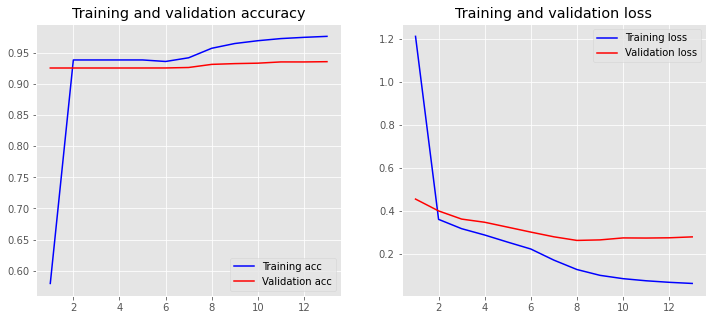

1000/1000 [==============================] - 26s 26ms/step
F1-score: 17.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.401906577693041,0.20770519262981574,0.27387293750812003,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.40175338288545837,0.11282682580886878,0.17617684544827727,37367.0
macro avg,0.2009532888465205,0.10385259631490787,0.13693646875406001,37367.0
weighted avg,0.21831829459184163,0.11282682580886878,0.14876957972381566,37367.0

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_28 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_28 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_28 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 150 samples, validate

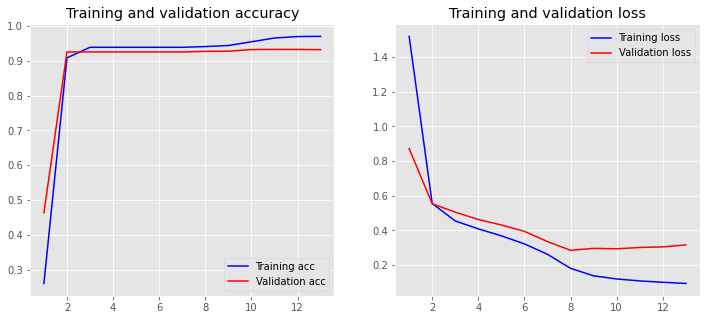

1000/1000 [==============================] - 26s 26ms/step
F1-score: 3.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.1346153846153846,0.00034486156271553846,0.0006879606879606879,20298.0
Disease,0.1426553672316384,0.047337278106508875,0.07108608630625082,17069.0
micro avg,0.14258222533240028,0.02181068857548104,0.03783394842513288,37367.0
macro avg,0.1386353759235115,0.023841069834612205,0.035887023497105756,37367.0
weighted avg,0.13828799583054333,0.02181068857548104,0.03284536176855571,37367.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_29 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_29 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_29 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 150 samples, validate on 1000 samples
Epoch 1/100
150/150 [==============================] - 121s 810ms/s

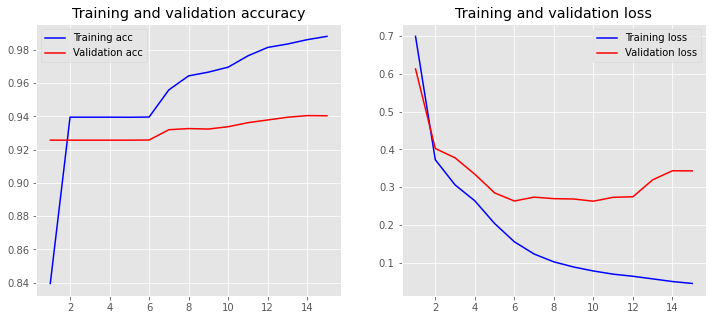

1000/1000 [==============================] - 26s 26ms/step
F1-score: 20.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.3494039041006157,0.2627845107892403,0.2999662580137218,20298.0
Disease,0.05782710280373832,0.0057999882828519535,0.01054256961823119,17069.0
micro avg,0.32000235599010485,0.1453956699761822,0.19994479712945074,37367.0
macro avg,0.20361550345217702,0.13429224953604613,0.1552544138159765,37367.0
weighted avg,0.2162135376988066,0.1453956699761822,0.16775941943362094,37367.0

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_30 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_30 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_30 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 150 samples, validate

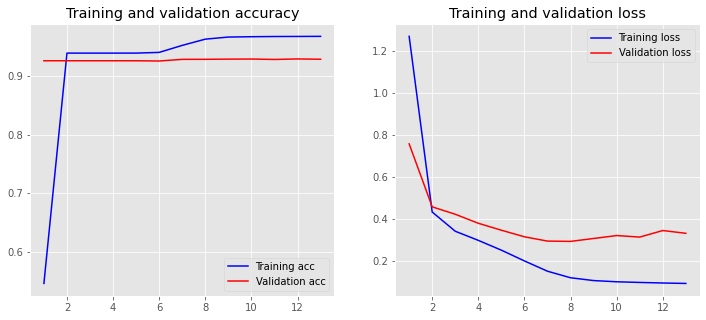

1000/1000 [==============================] - 27s 27ms/step
F1-score: 18.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.2765149517430515,0.25830131047393834,0.26709799026974707,20298.0
Disease,0.12162162162162163,0.0010545433241549006,0.0020909566126502874,17069.0
micro avg,0.2753152964571668,0.1407926780314181,0.18630922869891636,37367.0
macro avg,0.19906828668233656,0.1296779268990466,0.13459447344119868,37367.0
weighted avg,0.20576069660234753,0.1407926780314181,0.14604451909215763,37367.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 175
Points in y_train after augmentation: 175


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_31 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_31 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_31 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 175 samples, validate on 1000 samples
Epoch 1/100
175/175 [==============================] - 128s 729ms/s

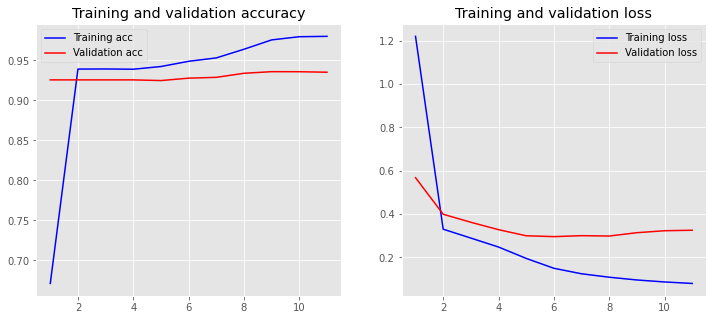

1000/1000 [==============================] - 27s 27ms/step
F1-score: 9.9%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.27276007215874926,0.13287245884351748,0.1786952410967539,17069.0
micro avg,0.27276007215874926,0.06069526587630797,0.0992951271835734,37367.0
macro avg,0.13638003607937463,0.06643622942175874,0.08934762054837694,37367.0
weighted avg,0.12459500820717988,0.06069526587630797,0.08162681163273723,37367.0

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Points in X_train after augmentation: 175
Points in y_train after augmentation: 175
Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_32 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_32 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_32 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 175 samples, validate

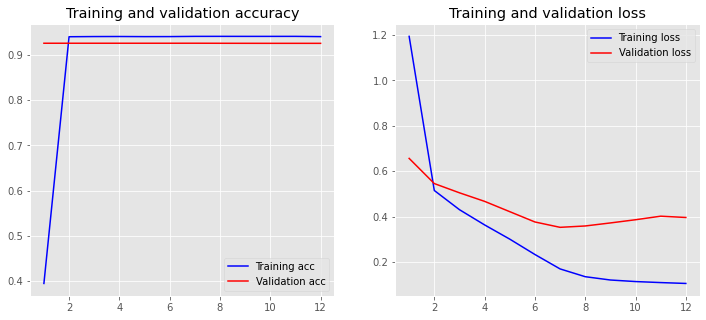

1000/1000 [==============================] - 27s 27ms/step
F1-score: 11.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7661129568106312,0.11360725194600453,0.19787197528745495,20298.0
Disease,0.012658227848101266,5.8585740230827815e-05,0.0001166316771635176,17069.0
micro avg,0.7468436387180317,0.061738967538202155,0.11404983191615582,37367.0
macro avg,0.3893855923293662,0.056832918843117676,0.09899430348230924,37367.0
weighted avg,0.42193978881048605,0.061738967538202155,0.10753863410180814,37367.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 175
Points in y_train after augmentation: 175


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_33 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_33 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_33 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 175 samples, validate on 1000 samples
Epoch 1/100
175/175 [==============================] - 128s 730ms/s

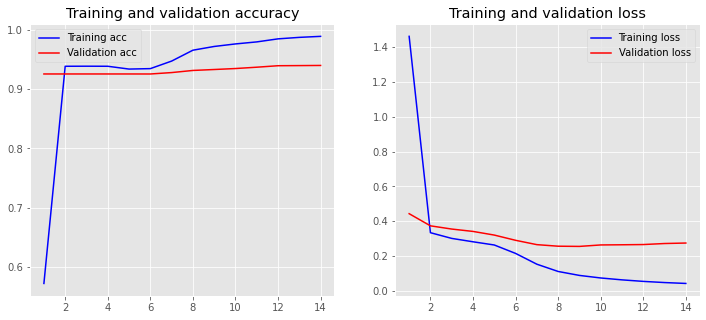

1000/1000 [==============================] - 27s 27ms/step
F1-score: 24.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.4952197006277161,0.2526357276578973,0.3345838906469188,20298.0
Disease,0.22517552657973922,0.10521998945456676,0.14342184068676384,17069.0
micro avg,0.37772080082919646,0.1852971873578291,0.24862652159862117,37367.0
macro avg,0.36019761360372765,0.17892785855623206,0.2390028656668413,37367.0
weighted avg,0.3718652968269047,0.1852971873578291,0.2472623226652803,37367.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 175
Points in y_train after augmentation: 175


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_34 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_34 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_34 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 175 samples, validate on 1000 samples
Epoch 1/100
175/175 [==============================] - 127s 728ms/s

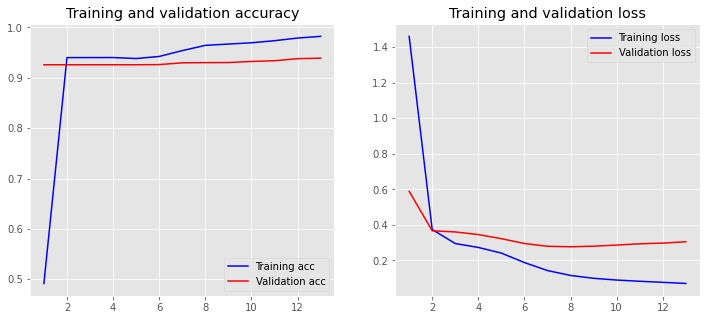

1000/1000 [==============================] - 27s 27ms/step
F1-score: 19.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.34749327632577065,0.24825105921765692,0.2896060231615851,20298.0
Disease,0.14285714285714285,5.8585740230827815e-05,0.00011712344811431249,17069.0
micro avg,0.34739454094292804,0.13487836861401772,0.1943132530120482,37367.0
macro avg,0.24517520959145675,0.12415482247894387,0.14486157330484972,37367.0
weighted avg,0.2540168355578201,0.13487836861401772,0.1573693964800417,37367.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 175
Points in y_train after augmentation: 175


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_35 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_35 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_35 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 175 samples, validate on 1000 samples
Epoch 1/100
175/175 [==============================] - 128s 731ms/s

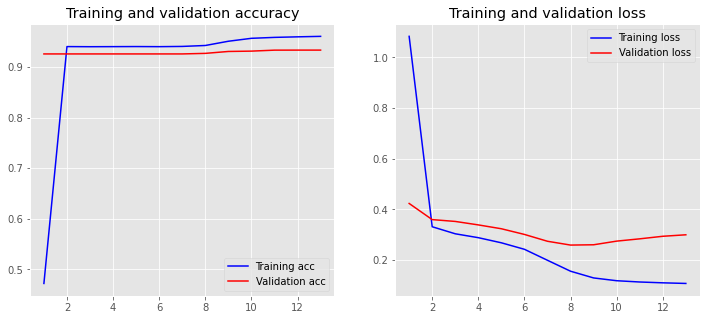

1000/1000 [==============================] - 27s 27ms/step
F1-score: 4.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.4520225776105362,0.05630089636182553,0.10013024225058609,17069.0
micro avg,0.4505391467416784,0.02571787941231568,0.04865822784810127,37367.0
macro avg,0.2260112888052681,0.028150448180912765,0.050065121125293044,37367.0
weighted avg,0.2064809424688694,0.02571787941231568,0.04573883653960056,37367.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 175
Points in y_train after augmentation: 175


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_36 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_36 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_36 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 175 samples, validate on 1000 samples
Epoch 1/100
175/175 [==============================] - 128s 733ms/s

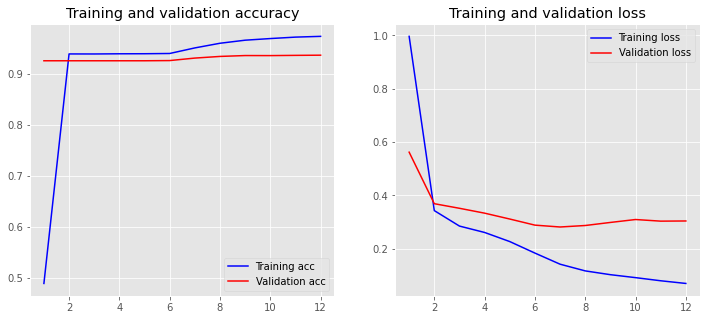

1000/1000 [==============================] - 28s 28ms/step
F1-score: 12.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.40750863060989645,0.1395704010247315,0.2079266055045872,20298.0
Disease,0.03286384976525822,0.0012303005448473842,0.0023718093517054437,17069.0
micro avg,0.37597154525095505,0.07637755238579495,0.1269629431914231,37367.0
macro avg,0.22018624018757732,0.07040035078478944,0.10514920742814632,37367.0
weighted avg,0.23637335712695348,0.07637755238579495,0.11403052566051253,37367.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 175
Points in y_train after augmentation: 175


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_37 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_37 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_37 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 175 samples, validate on 1000 samples
Epoch 1/100
175/175 [==============================] - 128s 731ms/s

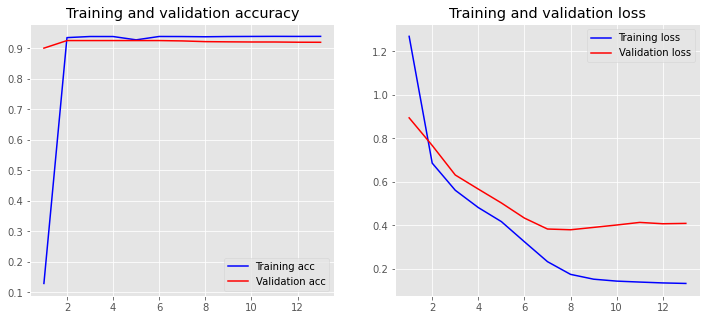

1000/1000 [==============================] - 28s 28ms/step
F1-score: 0.4%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.010783422112511367,0.0040890728150556705,0.005929630291123415,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.010783422112511367,0.0022212112291594187,0.0036836499201136157,37367.0
macro avg,0.005391711056255684,0.0020445364075278353,0.0029648151455617076,37367.0
weighted avg,0.005857625767114185,0.0022212112291594187,0.0032210141474890435,37367.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 175
Points in y_train after augmentation: 175


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_38 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_38 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_38 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_38 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 175 samples, validate on 1000 samples
Epoch 1/100
175/175 [==============================] - 128s 732ms/s

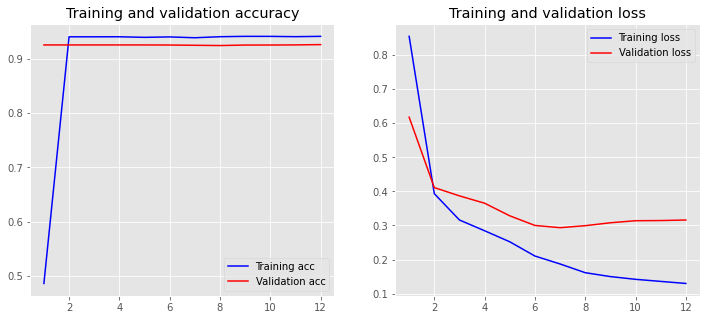

1000/1000 [==============================] - 28s 28ms/step
F1-score: 0.1%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.006700915791824883,0.0014779781259237363,0.0024217961654894042,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.006700915791824883,0.000802847432226296,0.0014338973329509608,37367.0
macro avg,0.0033504578959124413,0.0007389890629618681,0.0012108980827447021,37367.0
weighted avg,0.0036399815008553394,0.000802847432226296,0.0013155355946986359,37367.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 175
Points in y_train after augmentation: 175


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_39 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_39 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_39 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_39 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 175 samples, validate on 1000 samples
Epoch 1/100
175/175 [==============================] - 129s 736ms/s

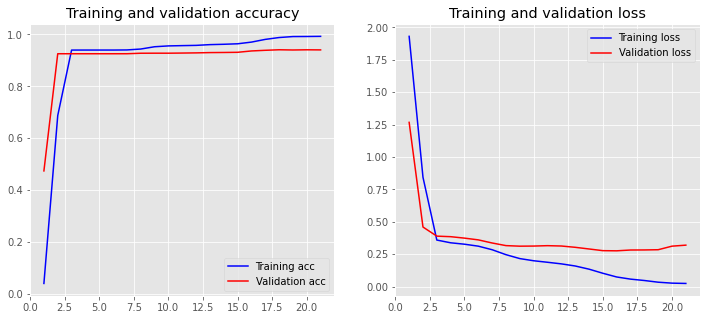

1000/1000 [==============================] - 28s 28ms/step
F1-score: 26.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.683377308707124,0.08931914474332446,0.15798875865975337,20298.0
Disease,0.44674141555711283,0.29878727517722187,0.35808320168509744,17069.0
micro avg,0.4913639917549222,0.1850028099660128,0.2688000622132359,37367.0
macro avg,0.5650593621321184,0.19405320996027317,0.2580359801724254,37367.0
weighted avg,0.575283588039756,0.1850028099660128,0.24939058508412776,37367.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 175
Points in y_train after augmentation: 175


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_40 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_40 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_40 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_40 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 175 samples, validate on 1000 samples
Epoch 1/100
175/175 [==============================] - 128s 734ms/s

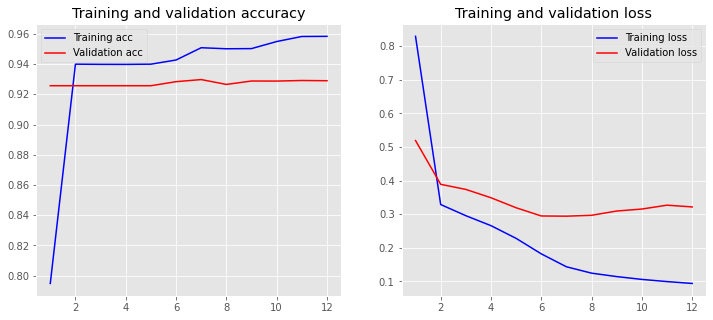

1000/1000 [==============================] - 29s 29ms/step
F1-score: 15.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.0064516129032258064,4.926593753079121e-05,9.778516599031927e-05,20298.0
Disease,0.2895511669658887,0.23621770461069774,0.2601793895592695,17069.0
micro avg,0.2864346590909091,0.10792945647228838,0.1567827084183723,37367.0
macro avg,0.14800138993455725,0.11813348527411427,0.1301385873626299,37367.0
weighted avg,0.13576962848637653,0.10792945647228838,0.11890135262896252,37367.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 200
Points in y_train after augmentation: 200
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_1 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________

Train on 200 samples

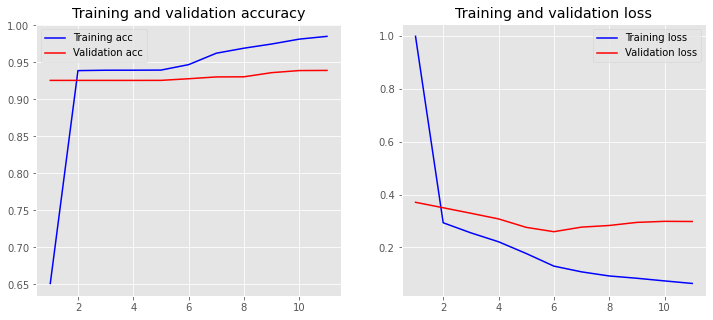

1000/1000 [==============================] - 22s 22ms/step
F1-score: 18.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.3314677074895059,0.22174598482609123,0.2657260087965286,20298.0
Disease,0.4254473161033797,0.012537348409397154,0.024356931481903033,17069.0
micro avg,0.33482459877858256,0.1261808547648995,0.1832883049233221,37367.0
macro avg,0.3784575117964428,0.1171416666177442,0.1450414701392158,37367.0
weighted avg,0.37439697500978353,0.1261808547648995,0.15547020071230067,37367.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 200
Points in y_train after augmentation: 200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_2 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 1000 samples
Epoch 1/100
200/200 [==============================] - 129s 644ms/st

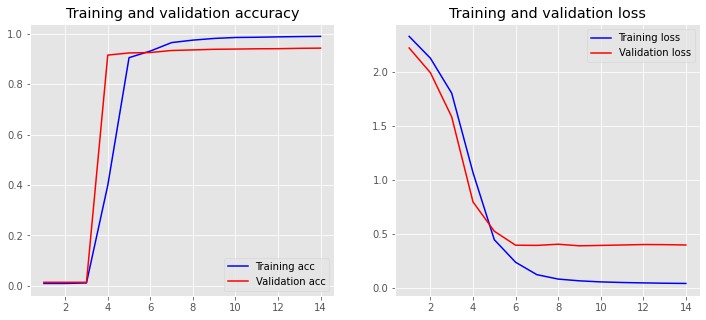

1000/1000 [==============================] - 21s 21ms/step
F1-score: 36.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6583415354330708,0.2636220317272638,0.3764863153451066,20298.0
Disease,0.47957687473816507,0.2682641045169606,0.3440658225945824,17069.0
micro avg,0.5617786829599457,0.265742500066904,0.36080882219355775,37367.0
macro avg,0.5689592050856179,0.2659430681221122,0.36027606896984454,37367.0
weighted avg,0.576683013384168,0.265742500066904,0.36167684734503447,37367.0

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Points in X_train after augmentation: 200
Points in y_train after augmentation: 200
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_3 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate 

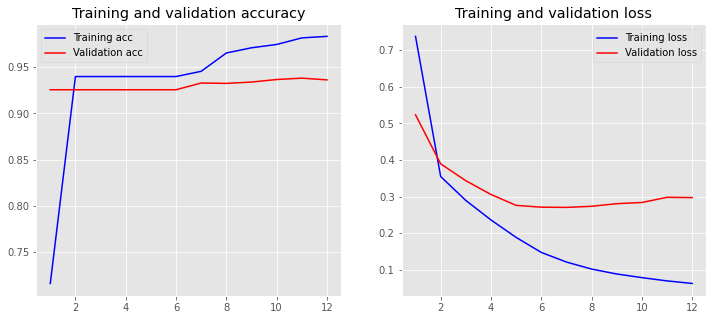

1000/1000 [==============================] - 22s 22ms/step
F1-score: 20.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.4762042948345908,0.24253621046408513,0.32138660399529967,20298.0
Disease,0.18181818181818182,0.00011717148046165563,0.000234192037470726,17069.0
micro avg,0.47589139047250945,0.13180078679048357,0.20642970911224742,37367.0
macro avg,0.32901123832638635,0.12132669097227339,0.1608103980163852,37367.0
weighted avg,0.3417306533039064,0.13180078679048357,0.17468629303353708,37367.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 200
Points in y_train after augmentation: 200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_4 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 1000 samples
Epoch 1/100
200/200 [==============================] - 131s 654ms/st

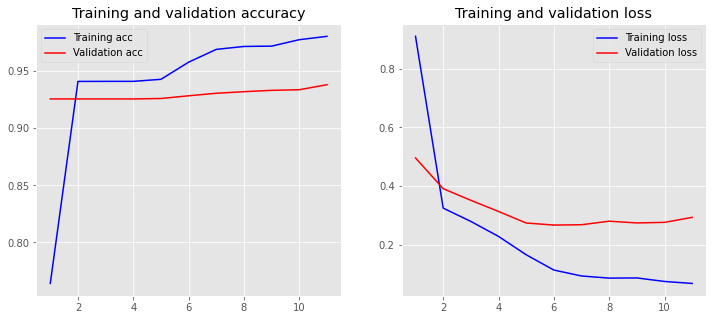

1000/1000 [==============================] - 22s 22ms/step
F1-score: 16.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.32591199699135015,0.21346930732091832,0.25797041050218794,20298.0
Disease,0.0645638245441104,0.007674731970238444,0.01371871400146612,17069.0
micro avg,0.2913077525450274,0.11946369791527284,0.16944070144806514,37367.0
macro avg,0.19523791076773028,0.11057201964557838,0.13584456225182703,37367.0
weighted avg,0.2065298695660301,0.11946369791527284,0.14639784092018188,37367.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 200
Points in y_train after augmentation: 200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_5 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 1000 samples
Epoch 1/100
200/200 [==============================] - 130s 651ms/st

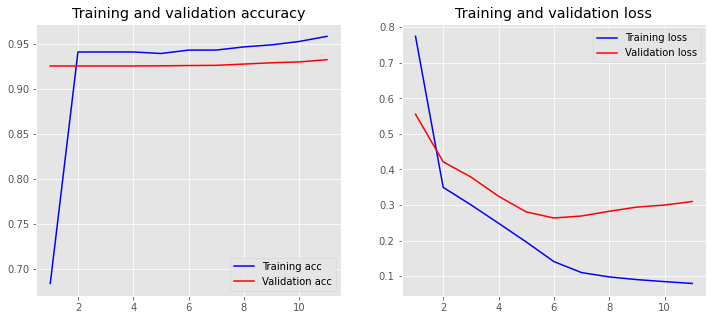

1000/1000 [==============================] - 22s 22ms/step
F1-score: 0.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.02127659574468085,9.853187506158242e-05,0.00019615535504119262,20298.0
Disease,0.030120481927710843,0.003515144413849669,0.006295577356906773,17069.0
micro avg,0.029721955896452542,0.0016592180266010116,0.003142980254986946,37367.0
macro avg,0.02569853883619585,0.0018068381444556257,0.003245866355973983,37367.0
weighted avg,0.025316424825370734,0.0016592180266010116,0.0029823312361620643,37367.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 200
Points in y_train after augmentation: 200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_6 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 1000 samples
Epoch 1/100
200/200 [==============================] - 135s 673ms/st

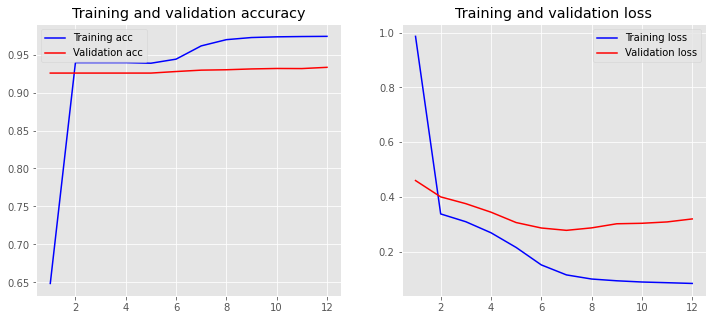

1000/1000 [==============================] - 22s 22ms/step
F1-score: 18.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.3290429728046502,0.23425953295891222,0.273676940343607,20298.0
Disease,0.12991538078646092,0.01529087820024606,0.027361358632980396,17069.0
micro avg,0.30473876063183475,0.1342360906682367,0.18637486763148609,37367.0
macro avg,0.22947917679555557,0.12477520557957913,0.1505191494882937,37367.0
weighted avg,0.23808279756557635,0.1342360906682367,0.1611616015628998,37367.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 200
Points in y_train after augmentation: 200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_7 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_7 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 1000 samples
Epoch 1/100
200/200 [==============================] - 133s 666ms/st

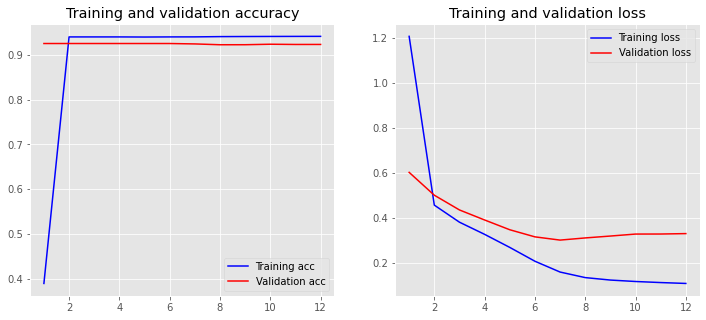

1000/1000 [==============================] - 23s 23ms/step
F1-score: 0.3%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.01751487111698612,0.0026110946891319342,0.004544675012862288,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.01751487111698612,0.0014183637969331228,0.0026242170673136432,37367.0
macro avg,0.00875743555849306,0.0013055473445659671,0.002272337506431144,37367.0
weighted avg,0.009514193109764878,0.0014183637969331228,0.0024686973375191673,37367.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 200
Points in y_train after augmentation: 200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_8 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 1000 samples
Epoch 1/100
200/200 [==============================] - 131s 653ms/st

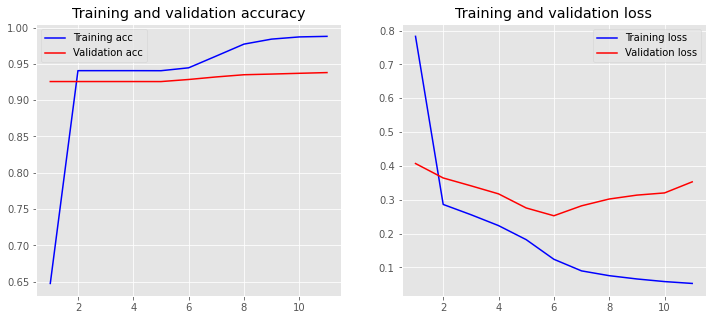

1000/1000 [==============================] - 22s 22ms/step
F1-score: 9.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.14855072463768115,0.006059710316287319,0.011644419199091165,20298.0
Disease,0.19458687063965704,0.1356259886343664,0.1598425740523372,17069.0
micro avg,0.19159135559921414,0.06524473465892365,0.0973408927573265,37367.0
macro avg,0.1715687976386691,0.07084284947532686,0.08574349662571419,37367.0
weighted avg,0.1695797335521706,0.06524473465892365,0.07934036228229444,37367.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 200
Points in y_train after augmentation: 200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 651)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_9 (TimeDist (None, 651, 5)            1505      
_________________________________________________________________
crf_9 (CRF)                  (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 1000 samples
Epoch 1/100
200/200 [==============================] - 134s 669ms/st

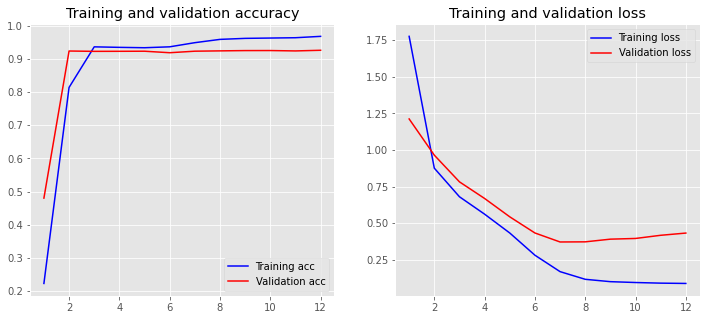

1000/1000 [==============================] - 24s 24ms/step
F1-score: 14.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.19519356733071327,0.21287811607054882,0.20365264522210438,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.19495578415448475,0.11563679182166083,0.1451680636979053,37367.0
macro avg,0.09759678366535664,0.10643905803527441,0.10182632261105219,37367.0
weighted avg,0.10603042871193348,0.11563679182166083,0.11062545542104732,37367.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 200
Points in y_train after augmentation: 200


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_10 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 1000 samples
Epoch 1/100
200/200 [==============================] - 140s 700ms/s

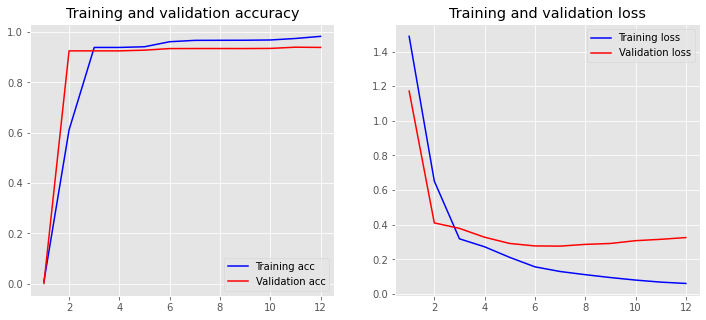

1000/1000 [==============================] - 23s 23ms/step
F1-score: 24.4%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.841947210368263,0.2624396492265248,0.400150234741784,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.841947210368263,0.14255894238231595,0.243832105094521,37367.0
macro avg,0.4209736051841315,0.1312198246132624,0.200075117370892,37367.0
weighted avg,0.4573512584915836,0.14255894238231595,0.21736423755690132,37367.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 600
Points in y_train after augmentation: 600


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_11 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_11 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 600 samples, validate on 1000 samples
Epoch 1/100
600/600 [==============================] - 72s 120ms/st

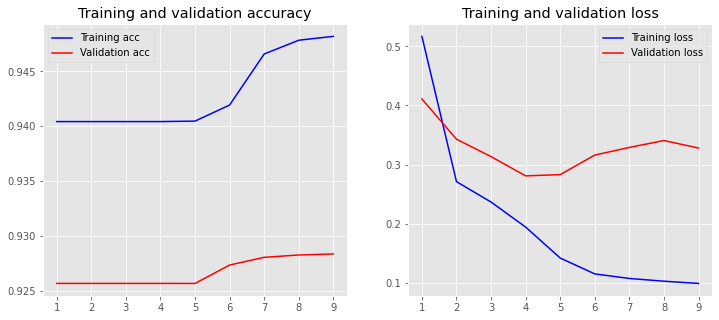

1000/1000 [==============================] - 23s 23ms/step
F1-score: 0.0%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.0,0.0,0.0,37367.0
macro avg,0.0,0.0,0.0,37367.0
weighted avg,0.0,0.0,0.0,37367.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 600
Points in y_train after augmentation: 600


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_12 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 600 samples, validate on 1000 samples
Epoch 1/100
600/600 [==============================] - 73s 121ms/st

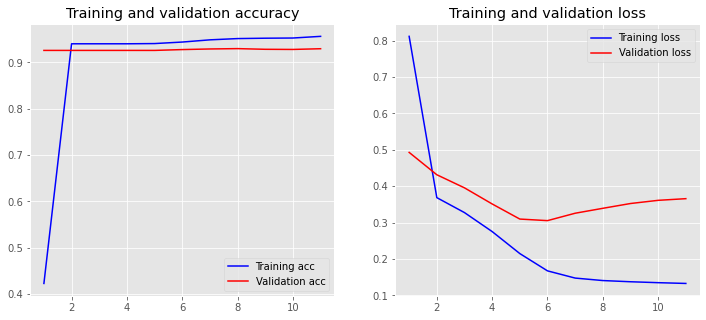

1000/1000 [==============================] - 24s 24ms/step
F1-score: 7.5%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.2579477494491659,0.0960220282383268,0.1399479144430688,17069.0
micro avg,0.2579477494491659,0.04386223138062997,0.07497541227327828,37367.0
macro avg,0.12897387472458294,0.0480110141191634,0.0699739572215344,37367.0
weighted avg,0.11782883654957081,0.043862231380629974,0.06392728748973,37367.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 600
Points in y_train after augmentation: 600


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_13 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_13 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 600 samples, validate on 1000 samples
Epoch 1/100
600/600 [==============================] - 72s 121ms/st

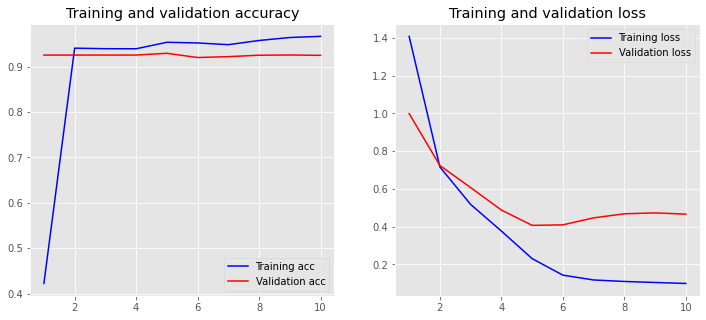

1000/1000 [==============================] - 24s 24ms/step
F1-score: 16.7%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.2774869109947644,0.21933195388708246,0.2450057784381707,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.2774869109947644,0.11914255894238232,0.1667072325925371,37367.0
macro avg,0.1387434554973822,0.10966597694354123,0.12250288921908535,37367.0
weighted avg,0.1507327138751232,0.11914255894238232,0.13308874918345034,37367.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 600
Points in y_train after augmentation: 600


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_14 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_14 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 600 samples, validate on 1000 samples
Epoch 1/100
600/600 [==============================] - 73s 121ms/st

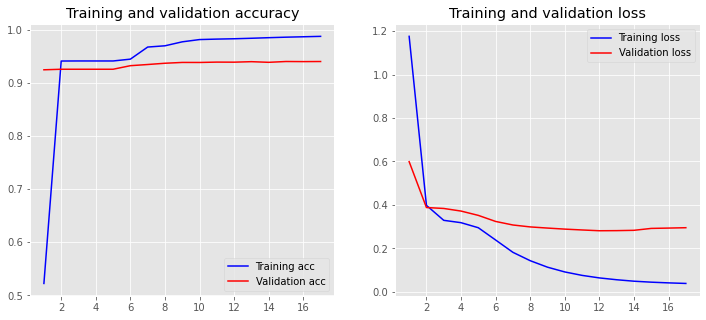

1000/1000 [==============================] - 24s 24ms/step
F1-score: 34.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7233637229555041,0.2618977239136861,0.384562520345788,20298.0
Disease,0.40561959654178675,0.23088640224969242,0.2942691805114803,17069.0
micro avg,0.5424553179021389,0.24773195600396072,0.3401308054085832,37367.0
macro avg,0.5644916597486455,0.24639206308168926,0.33941585042863415,37367.0
weighted avg,0.5782202944288432,0.24773195600396072,0.34331711617548266,37367.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 600
Points in y_train after augmentation: 600


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_15 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_15 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 600 samples, validate on 1000 samples
Epoch 1/100
600/600 [==============================] - 71s 119ms/st

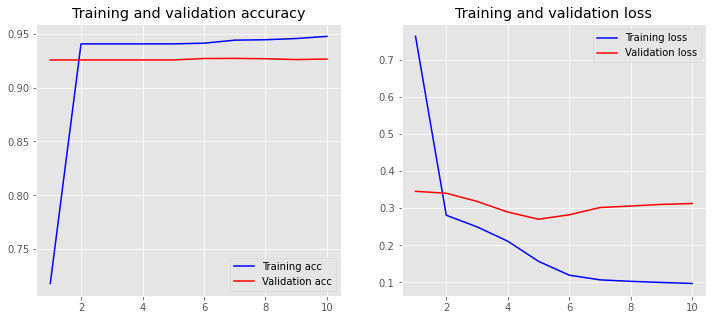

1000/1000 [==============================] - 25s 25ms/step
F1-score: 0.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.1,4.926593753079121e-05,9.848335631278314e-05,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.0625,2.6761581074209864e-05,5.350025412620709e-05,37367.0
macro avg,0.05,2.4632968765395605e-05,4.924167815639157e-05,37367.0
weighted avg,0.05432065726443119,2.6761581074209864e-05,5.3496806445175474e-05,37367.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 600
Points in y_train after augmentation: 600


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_16 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_16 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 600 samples, validate on 1000 samples
Epoch 1/100
600/600 [==============================] - 75s 126ms/st

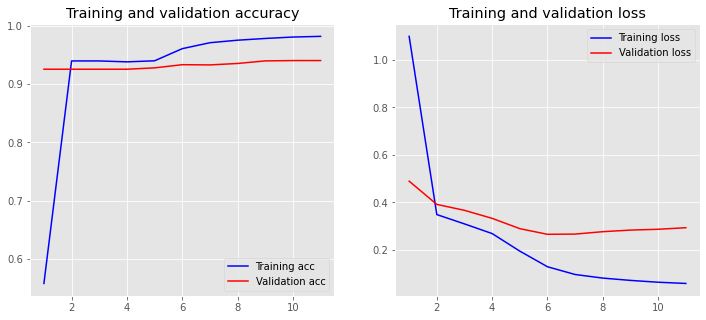

1000/1000 [==============================] - 26s 26ms/step
F1-score: 23.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6001114206128134,0.26534633954084147,0.36798414921600114,20298.0
Disease,0.14814814814814814,0.000937371843693245,0.0018629562787448332,17069.0
micro avg,0.5947374215567544,0.1445660609628817,0.23259418729817008,37367.0
macro avg,0.3741297843804808,0.13314185569226736,0.184923552747373,37367.0
weighted avg,0.3936575683447862,0.1445660609628817,0.20074239466663865,37367.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 600
Points in y_train after augmentation: 600


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_17 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_17 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 600 samples, validate on 1000 samples
Epoch 1/100
600/600 [==============================] - 78s 130ms/st

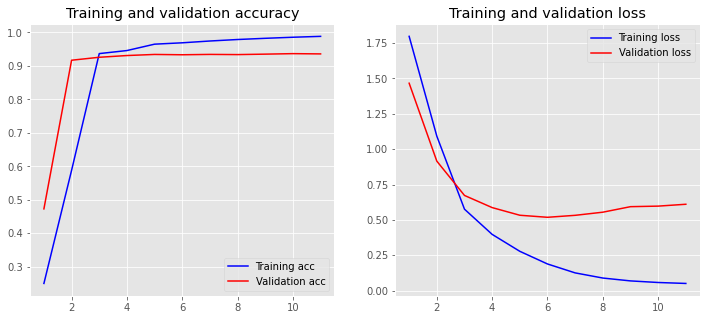

1000/1000 [==============================] - 27s 27ms/step
F1-score: 22.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.48628884826325414,0.2620947876638092,0.3406107945451053,20298.0
Disease,0.15151515151515152,0.01933329427617318,0.03429105834675534,17069.0
micro avg,0.4307059002896783,0.15120293306928573,0.2238288600574428,37367.0
macro avg,0.3189019998892028,0.1407140409699912,0.1874509264459303,37367.0
weighted avg,0.33336642393715454,0.15120293306928573,0.20068595238037076,37367.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 600
Points in y_train after augmentation: 600


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_18 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_18 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 600 samples, validate on 1000 samples
Epoch 1/100
600/600 [==============================] - 79s 131ms/st

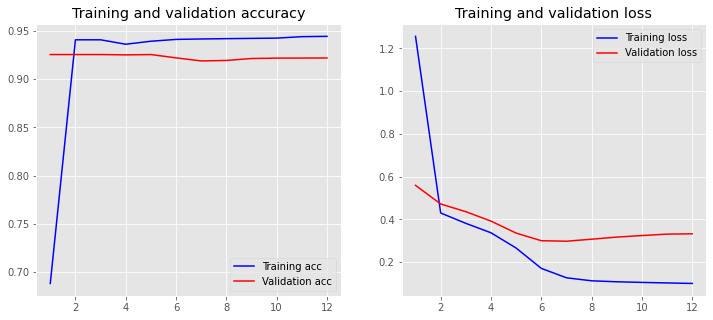

1000/1000 [==============================] - 26s 26ms/step
F1-score: 19.3%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.29452730862031146,0.2646073504778796,0.2787668033425027,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.29452730862031146,0.14373645194958118,0.19319101487329818,37367.0
macro avg,0.14726365431015573,0.1323036752389398,0.13938340167125135,37367.0
weighted avg,0.15998916986579287,0.14373645194958118,0.1514279598106918,37367.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 600
Points in y_train after augmentation: 600


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_19 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_19 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 600 samples, validate on 1000 samples
Epoch 1/100
600/600 [==============================] - 78s 130ms/st

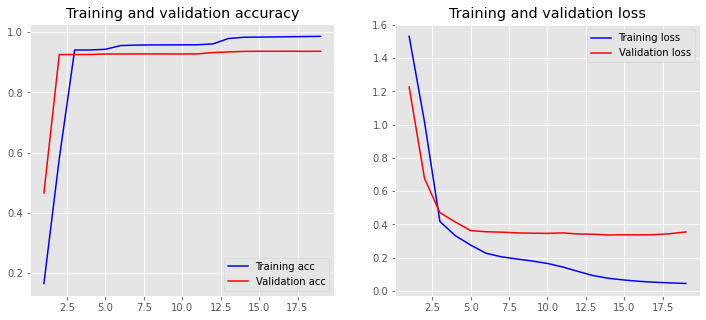

1000/1000 [==============================] - 27s 27ms/step
F1-score: 31.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.9088324151412831,0.25194600453246624,0.3945226615236258,20298.0
Disease,0.2715206432263417,0.24928232468217235,0.25992669517409894,17069.0
micro avg,0.4399004601371021,0.25072925308427224,0.3194068013295832,37367.0
macro avg,0.5901765291838124,0.2506141646073193,0.3272246783488624,37367.0
weighted avg,0.6177125865541304,0.25072925308427224,0.3330401087465745,37367.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 600
Points in y_train after augmentation: 600


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_20 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_20 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_20 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 600 samples, validate on 1000 samples
Epoch 1/100
600/600 [==============================] - 78s 130ms/st

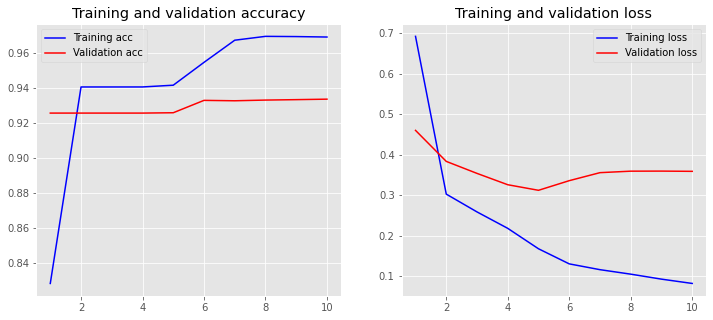

1000/1000 [==============================] - 27s 27ms/step
F1-score: 2.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.1354378818737271,0.019657109074785694,0.03433144037170883,20298.0
Disease,0.03435114503816794,0.0005272716620774503,0.001038601350181755,17069.0
micro avg,0.12718204488778054,0.010918725078277625,0.020110905730129393,37367.0
macro avg,0.08489451345594752,0.010092190368431573,0.01768502086094529,37367.0
weighted avg,0.08926212489440954,0.010918725078277625,0.01912349032866428,37367.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 1000% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1100
Points in y_train after augmentation: 1100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_21 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_21 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 1100 samples, validate on 1000 samples
Epoch 1/100
1100/1100 [==============================] - 63s 57ms/

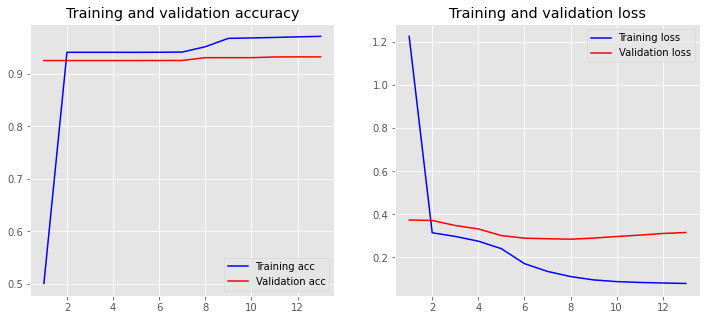

1000/1000 [==============================] - 27s 27ms/step
F1-score: 19.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.3184744619535226,0.25588727953492957,0.28377086349605274,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.3184549356223176,0.13899965209944604,0.19352795424483482,37367.0
macro avg,0.1592372309767613,0.12794363976746478,0.14188543174802637,37367.0
weighted avg,0.1729974209525143,0.13899965209944604,0.15414619817600766,37367.0

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1100
Points in y_train after augmentation: 1100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_22 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_22 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 1100 samples, validate on 1000 samples
Epoch 1/100
1100/1100 [==============================] - 64s 58ms/

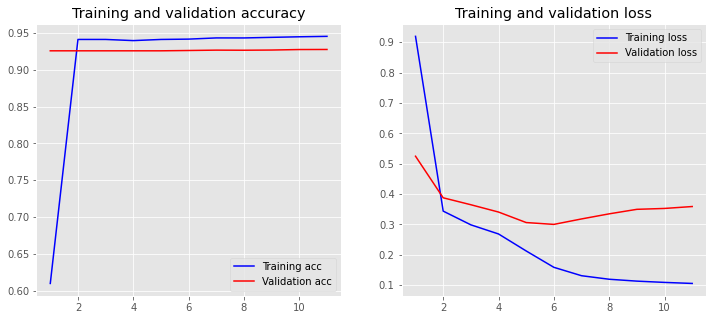

1000/1000 [==============================] - 27s 27ms/step
F1-score: 0.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.026865671641791045,0.0004433934377771209,0.0008723888915814473,20298.0
Disease,0.037914691943127965,0.0028121155310797353,0.005235887646577585,17069.0
micro avg,0.03560274828232355,0.0015254101212299623,0.0029254773147197703,37367.0
macro avg,0.032390181792459505,0.001627754484428428,0.003054138269079516,37367.0
weighted avg,0.03191279149416131,0.0015254101212299623,0.002865606443138411,37367.0

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1100
Points in y_train after augmentation: 1100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_23 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_23 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_23 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 1100 samples, validate on 1000 samples
Epoch 1/100
1100/1100 [==============================] - 64s 58ms/

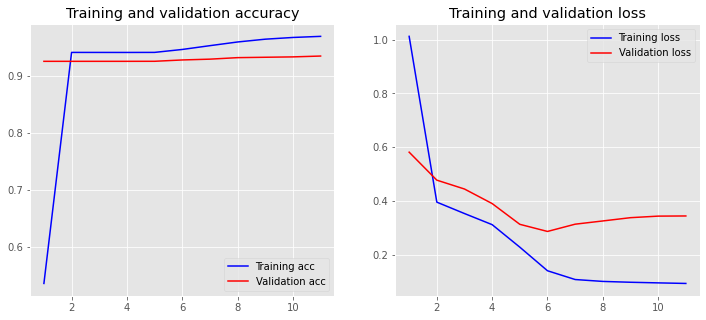

1000/1000 [==============================] - 28s 28ms/step
F1-score: 6.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.011051143664867643,0.002118435313824022,0.003555335069659762,20298.0
Disease,0.5149722735674677,0.08160993614154315,0.1408920805097603,17069.0
micro avg,0.21770770163735598,0.038429630422565364,0.06532766189750472,37367.0
macro avg,0.2630117086161676,0.041864185727683585,0.07222370778971003,37367.0
weighted avg,0.24123900371002727,0.038429630422565364,0.06628985772111896,37367.0

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1100
Points in y_train after augmentation: 1100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_24 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_24 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_24 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 1100 samples, validate on 1000 samples
Epoch 1/100
1100/1100 [==============================] - 63s 57ms/

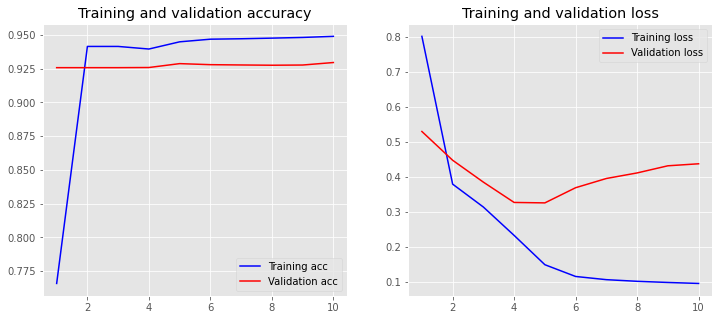

1000/1000 [==============================] - 28s 28ms/step
F1-score: 9.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.24800387127994192,0.12010076747319702,0.16183145845668048,17069.0
micro avg,0.24797387202128945,0.05486124120213022,0.08984529079195337,37367.0
macro avg,0.12400193563997096,0.06005038373659851,0.08091572922834024,37367.0
weighted avg,0.11328653835944359,0.05486124120213022,0.07392354656239675,37367.0

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1100
Points in y_train after augmentation: 1100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_25 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_25 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_25 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 1100 samples, validate on 1000 samples
Epoch 1/100
1100/1100 [==============================] - 63s 58ms/

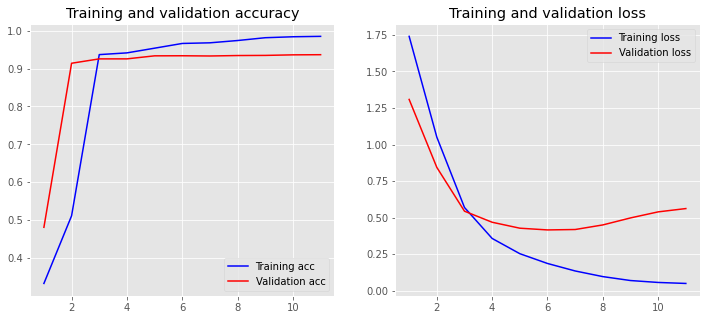

1000/1000 [==============================] - 28s 28ms/step
F1-score: 22.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6417744916820702,0.25657700266036065,0.3665927568366593,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.640590405904059,0.139374314234485,0.2289381717475878,37367.0
macro avg,0.3208872458410351,0.12828850133018033,0.18329637841832966,37367.0
weighted avg,0.3486161220371628,0.139374314234485,0.19913559499747133,37367.0

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1100
Points in y_train after augmentation: 1100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_26 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_26 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_26 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 1100 samples, validate on 1000 samples
Epoch 1/100
1100/1100 [==============================] - 64s 58ms/

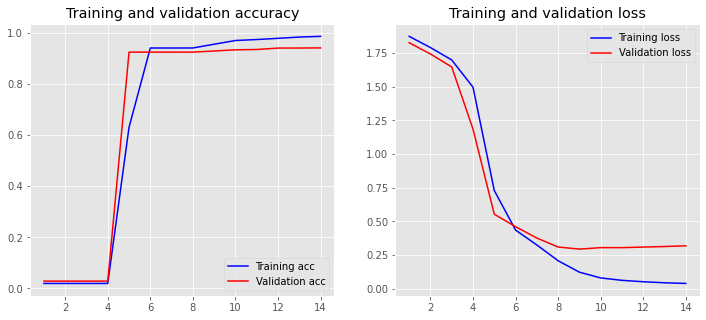

1000/1000 [==============================] - 28s 28ms/step
F1-score: 20.1%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.33742176139596636,0.2629323086018327,0.2955558632147307,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.33742176139596636,0.14282655819305803,0.2006994584837545,37367.0
macro avg,0.16871088069798318,0.13146615430091635,0.14777793160736535,37367.0
weighted avg,0.18328971854350964,0.14282655819305803,0.1605478874818049,37367.0

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1100
Points in y_train after augmentation: 1100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_27 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_27 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_27 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 1100 samples, validate on 1000 samples
Epoch 1/100
1100/1100 [==============================] - 65s 59ms/

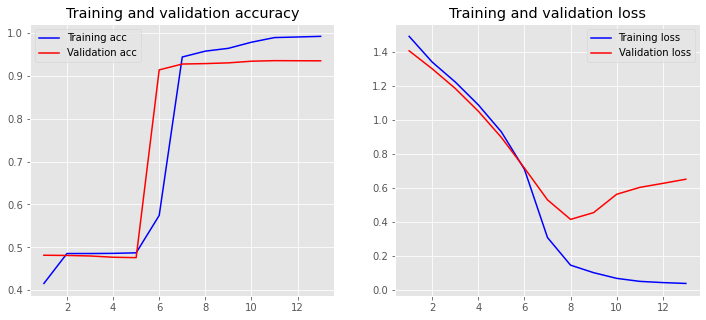

1000/1000 [==============================] - 28s 28ms/step
F1-score: 16.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.000999000999000999,4.926593753079121e-05,9.390112211840932e-05,20298.0
Disease,0.3197895352236188,0.25637119925010254,0.2845901212889799,17069.0
micro avg,0.29805924412665985,0.11713544036181657,0.16817797587028357,37367.0
macro avg,0.1603942681113099,0.12821023259381667,0.14234201120554918,37367.0
weighted avg,0.14662042173601497,0.11713544036181657,0.13004990460187754,37367.0

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1100
Points in y_train after augmentation: 1100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_28 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_28 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_28 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 1100 samples, validate on 1000 samples
Epoch 1/100
1100/1100 [==============================] - 63s 57ms/

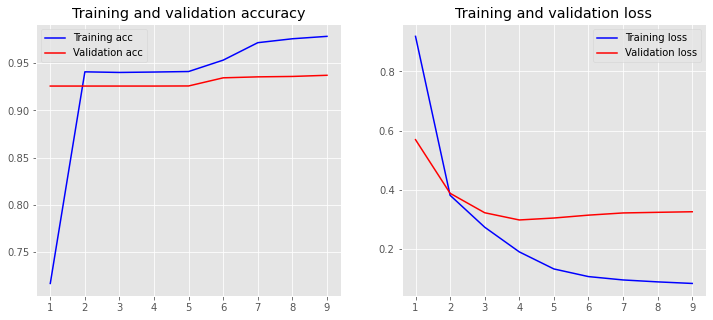

1000/1000 [==============================] - 28s 28ms/step
F1-score: 0.0%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.0,0.0,0.0,37367.0
macro avg,0.0,0.0,0.0,37367.0
weighted avg,0.0,0.0,0.0,37367.0

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1100
Points in y_train after augmentation: 1100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_29 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_29 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_29 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 1100 samples, validate on 1000 samples
Epoch 1/100
1100/1100 [==============================] - 63s 57ms/

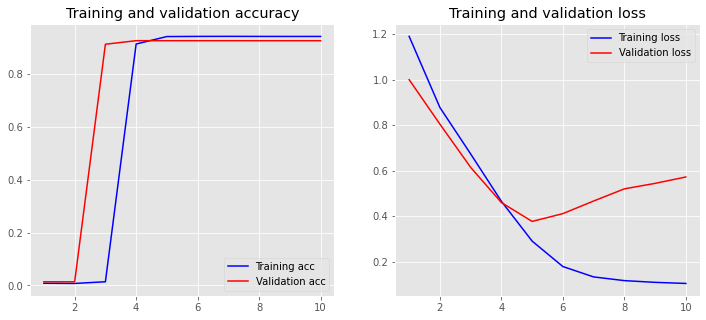

1000/1000 [==============================] - 28s 28ms/step
F1-score: 0.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.02564102564102564,4.926593753079121e-05,9.834292176820574e-05,20298.0
Disease,0.0,0.0,0.0,17069.0
micro avg,0.01282051282051282,2.6761581074209864e-05,5.341167044999332e-05,37367.0
macro avg,0.01282051282051282,2.4632968765395605e-05,4.917146088410287e-05,37367.0
weighted avg,0.013928373657546457,2.6761581074209864e-05,5.3420521477534725e-05,37367.0

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1100
Points in y_train after augmentation: 1100


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 651)               0         
_________________________________________________________________
embedding_30 (Embedding)     (None, 651, 150)          2779950   
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 651, 300)          361200    
_________________________________________________________________
time_distributed_30 (TimeDis (None, 651, 5)            1505      
_________________________________________________________________
crf_30 (CRF)                 (None, 651, 5)            65        
Total params: 3,142,720
Trainable params: 3,142,720
Non-trainable params: 0
_________________________________________________________________
Train on 1100 samples, validate on 1000 samples
Epoch 1/100
1100/1100 [==============================] - 62s 57ms/

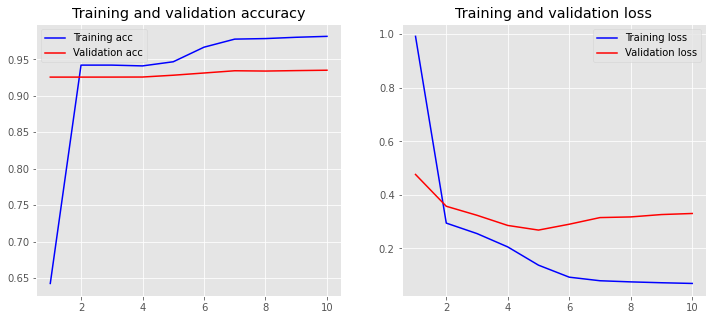

1000/1000 [==============================] - 29s 29ms/step
F1-score: 15.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.0,0.0,0.0,20298.0
Disease,0.33641229281767954,0.228308629679536,0.2720134017380379,17069.0
micro avg,0.33635422061108233,0.10428988144619585,0.1592139399015382,37367.0
macro avg,0.16820614640883977,0.114154314839768,0.13600670086901895,37367.0
weighted avg,0.1536709242407732,0.10428988144619585,0.12425393406659804,37367.0



In [13]:
number_of_training_models = 10
target_augmented_percentage = 10

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)